In [1]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense 
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import plot_model
import os
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime as dt

Using TensorFlow backend.


In [2]:
print (tensorflow.__version__)

2.1.0


In [3]:
epoch = 200
batch_size = 32
training_samples = 4000
validation_samples = 600
img_width = 200
img_height = 200 
channels = 3
input_shape = (img_width,img_height,3)


In [4]:
train_data_dir = 'Small_set_malignant_vs_nonmalignant/train'
validation_data_dir = 'Small_set_malignant_vs_nonmalignant/val'


train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.4, 
    zoom_range=0.4, 
    rotation_range=20,
		width_shift_range=0.4,
		height_shift_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest") 


val_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary') 
  
validation_generator = val_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary') 


Found 255556 images belonging to 2 classes.
Found 42596 images belonging to 2 classes.


In [5]:
image_batch_1= next(train_generator)
print(len(image_batch_1[0]))

32


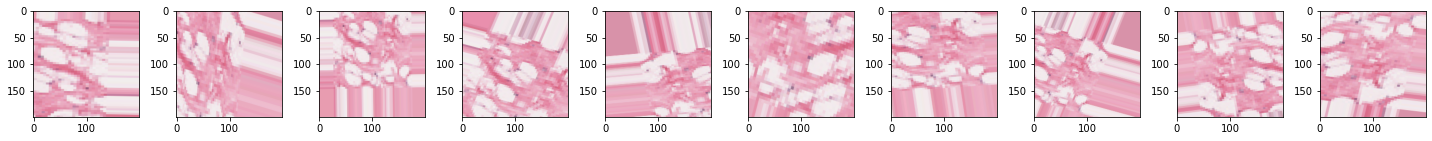

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(10)]
plotImages(augmented_images)

CNN Model creation, Model referenced from VGG16-Lite

In [7]:
model = Sequential() # Create the model


model.add(Conv2D(input_shape=(200,200,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# First 2 convolution layers with a maxpool of 2x2 and stride of 2x2

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# second 2 convoltion layers with a maxpool of 2x2 and stride of 2x2

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# third layer of 3 convolution layers with a maxpool of 2x2 and stride of 2x2

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# fourth layer of 3 convolution layers with a maxpool of 2x2 and stride of 2x2

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# fifth layer of 3 convolution layers with a maxpool of 2x2 and stride of 2x2

#Structure detailed by Karen Simonyan and Andrew Zisserman in
#VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION


Flatten the network into a fully connected decoder

In [8]:
model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
# First fully connected newtork of 4096 units

model.add(Dense(units=4096,activation="relu"))
# Second fully connected newtork of 4096 units

model.add(Dense(units=1000,activation="relu"))
# Third fully connected newtork of 1000 units

model.add(Dense(units=1, activation="sigmoid"))
# The soft-max output


In [9]:

sgd = tensorflow.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 256)       2

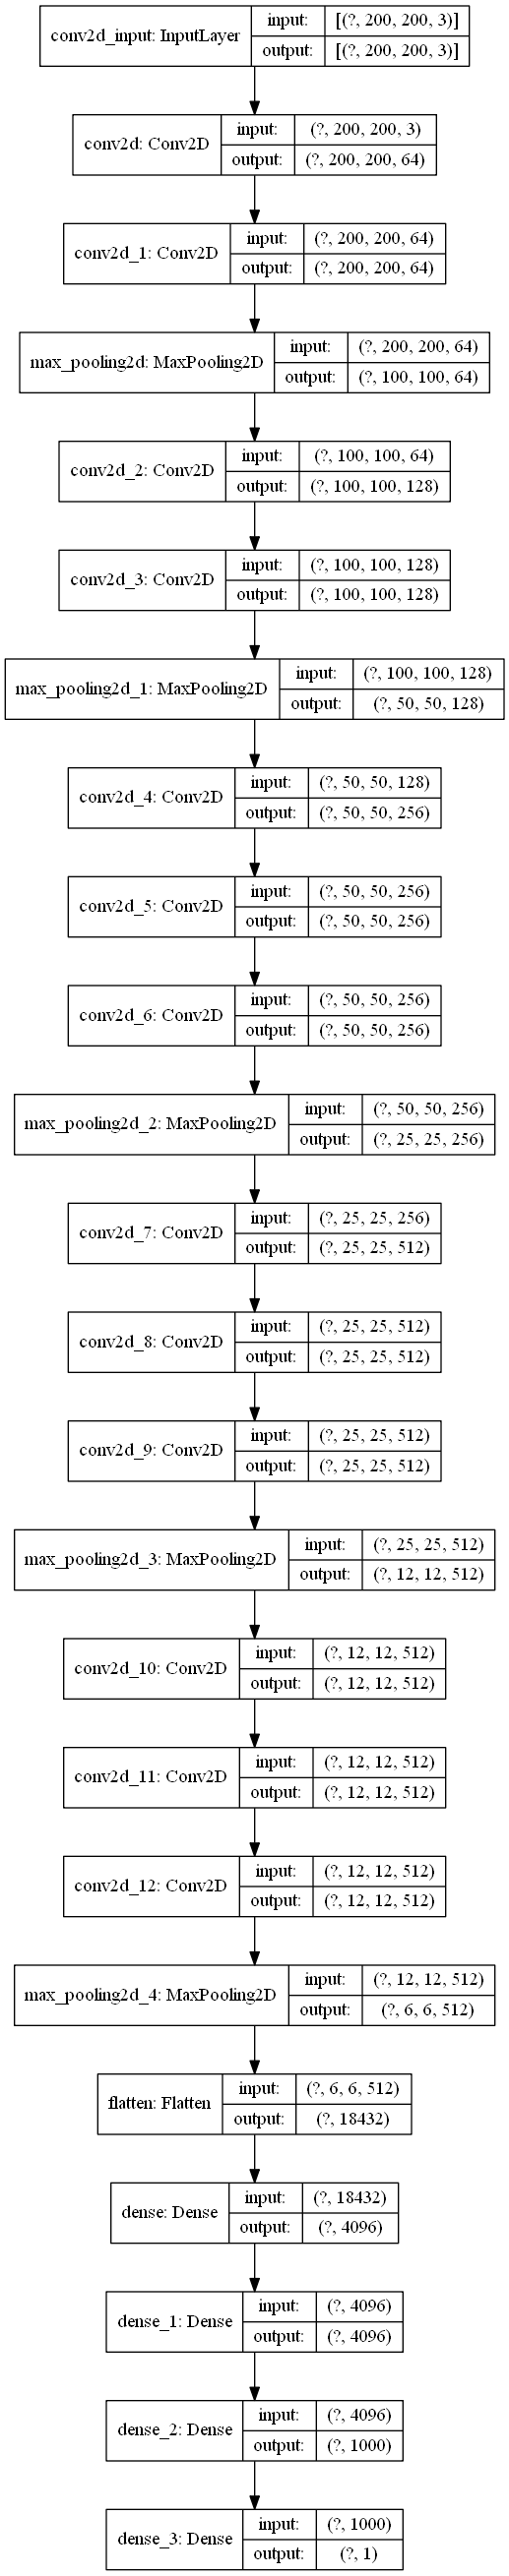

In [11]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [12]:

class EarlyStoppingAtLoss(tensorflow.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super(EarlyStoppingAtLoss, self).__init__()

        self.patience = patience

        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('loss')
        if np.less(current, self.best):
          self.best = current
          self.wait = 0
          # Record the best weights if current results is better (less).
          self.best_weights = self.model.get_weights()
        else:
          self.wait += 1
          if self.wait >= self.patience:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print('Restoring model weights with parameters from best epoch.')
            self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
          print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

In [13]:

class LossErrorCallback(tensorflow.keras.callbacks.Callback):
    
    def on_train_batch_end(self, batch, logs=None):
        print(' Training Batch Number {} : Loss rating {:7.2f}'.format(batch, logs['loss']))
    def on_test_batch_end(self, batch, logs=None):
        print(' Testing Batch Number {} : Loss rating {:7.2f}'.format(batch, logs['loss']))
    def on_epoch_end(self, batch, logs=None):
        print(' Epoch ended: average loss is {:7.2f} '.format(epoch, logs['loss']))

In [15]:


from keras.callbacks import ModelCheckpoint, EarlyStopping


snapshot_name = "vgg16_Ductal_Carcinoma_"
checkpoint = ModelCheckpoint(snapshot_name+".{epoch:02d}-{val_accuracy:.2f}.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

reduce_lr = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')
#patience updated, early stopping activating too early at low accuracy


hist = model.fit_generator(train_generator, 
                           steps_per_epoch=training_samples,
                           validation_data=validation_generator, 
                           validation_steps=validation_samples,
                           epochs=epoch,
                           callbacks=[checkpoint,reduce_lr]
                          )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4000 steps, validate for 600 steps
Epoch 1/200
3999/4000 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.7153
Epoch 00001: val_accuracy improved from -inf to 0.71724, saving model to vgg16_Ductal_Carcinoma_.01-0.72.hdf5
4000/4000 [==============================] - 1690s 422ms/step - loss: 0.2037 - accuracy: 0.7153 - val_loss: 0.2030 - val_accuracy: 0.7172
Epoch 2/200
3999/4000 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.7160
Epoch 00002: val_accuracy did not improve from 0.71724
4000/4000 [==============================] - 1679s 420ms/step - loss: 0.2034 - accuracy: 0.7160 - val_loss: 0.2028 - val_accuracy: 0.7172
Epoch 3/200
3999/4000 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.7159
Epoch 00003: val_accuracy did not improve from 0.71724
4000/4000 [==============================] - 1681s 420ms/step - loss: 0.2034 - accuracy: 0.7159 - val_loss: 0.20

In [17]:
#type(model_save_dir)
#print(model_save_dir)

#model.save(model_save_dir)
model.save_weights('vgg16_Ductal_Carcinoma_finished_model.h5')

In [18]:
test_data_dir = 'Small_set_malignant_vs_nonmalignant/test'

test_datagen = ImageDataGenerator(rescale=1. / 255) 

test_generator = test_datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary') 

Found 99743 images belonging to 2 classes.


In [19]:
model.evaluate_generator(test_generator,  verbose=2)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
3117/3117 - 1059s - loss: 0.0473 - accuracy: 0.9366


[0.04730376743546899, 0.93659705]

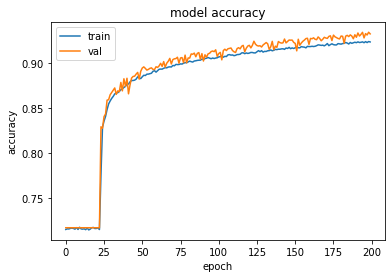

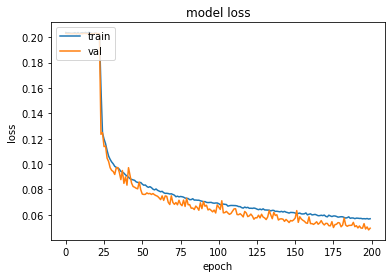

In [22]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

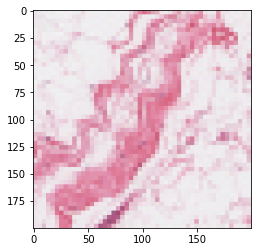

In [28]:
img = image.load_img('./Small_set_malignant_vs_nonmalignant/test/0/12872_idx5_x351_y1001_class0.png', target_size=(img_width, img_height))

plt.imshow(img)
plt.show()

In [29]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
# Prediction result
pred = model.predict(images)
print (pred)

# Class Prediction
pred_class = model.predict_classes(images)
print (pred_class)

[[0.]]
[[0]]


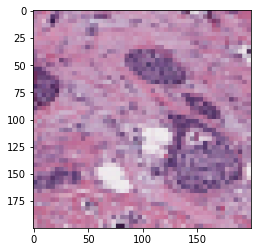

In [30]:
img_2 = image.load_img('./Small_set_malignant_vs_nonmalignant/test/1/12910_idx5_x1201_y201_class1.png', target_size=(img_width, img_height))
plt.imshow(img_2)
plt.show()

In [31]:
y = image.img_to_array(img_2)
y = np.expand_dims(y,axis=0)

images = np.vstack([x,y])
# Prediction result
pred = model.predict(images)
print (pred)

# Class Prediction
pred_class = model.predict_classes(images)
print (pred_class)

[[0.]
 [0.]]
[[0]
 [0]]
